In [1]:
%matplotlib inline

In [2]:
import numpy

import matplotlib.pyplot
import scipy.ndimage
import skimage.color
import skimage.exposure
import skimage.feature
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.restoration

In [3]:
matplotlib.pyplot.rcParams["image.cmap"] = "gray"
matplotlib.pyplot.rcParams["image.interpolation"] = "none"

In [4]:
# Function for displaying 16 slices from 3D data
def display(data, cmap="gray"):
    figure, axes = matplotlib.pyplot.subplots(nrows=4, ncols=4, figsize=(12, 12))
    
    for idx, (plane, ax) in enumerate(zip(data, axes.flatten())):
        ax.imshow(plane, cmap=cmap, vmin=data.min(), vmax=data.max())
            
        if idx / 4 < 3:
            ax.set_xticks([])
            
        if idx % 4 != 0:
            ax.set_yticks([])

# 3D image processing

This tutorial aims to highlight some of the three-dimensional image processing operations available in `scikit-image`. It is by no means comprehensive. In this tutorial we will segment anisotropic three-dimensional data of cells taken from a biology experiment.

Scikit-image requires three-dimenional data to be in the format `(plane, row, column)`. The data in this example has fewer planes than rows and columns due to how the image was captured, this information is captured in the `spacing` variable.

shape (plane, row, col): (16, 580, 580)
dtype: uint16


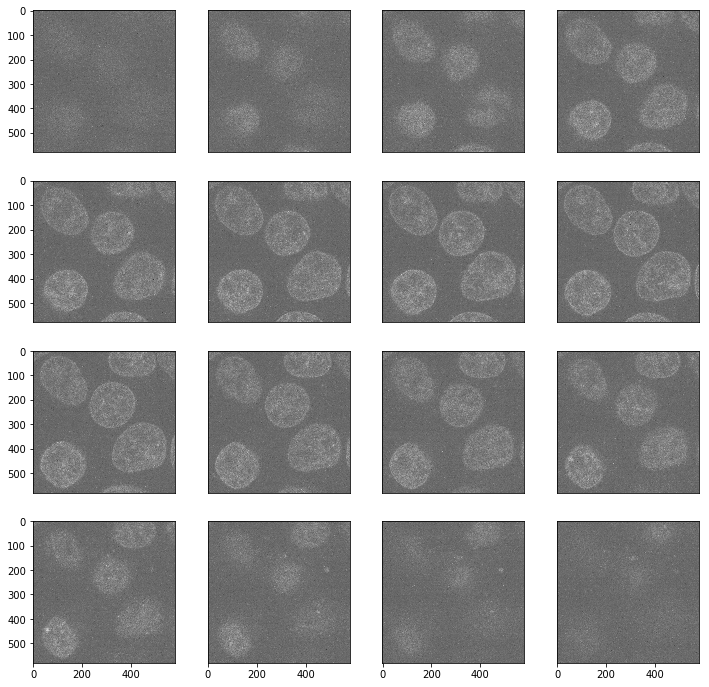

In [157]:
cells = skimage.io.imread("../../images/cells.tif")

spacing = (0.58, 0.065, 0.065)

print("shape (plane, row, col): {}".format(cells.shape))
print("dtype: {}".format(cells.dtype))

display(cells)

The range of the cell intensities is very small. We can visualize the low contrast using a histogram.

The contrast of the image can be improved using histogram equalization. `skimage.exposure.equalize_hist` is compatible with three-dimensional data.

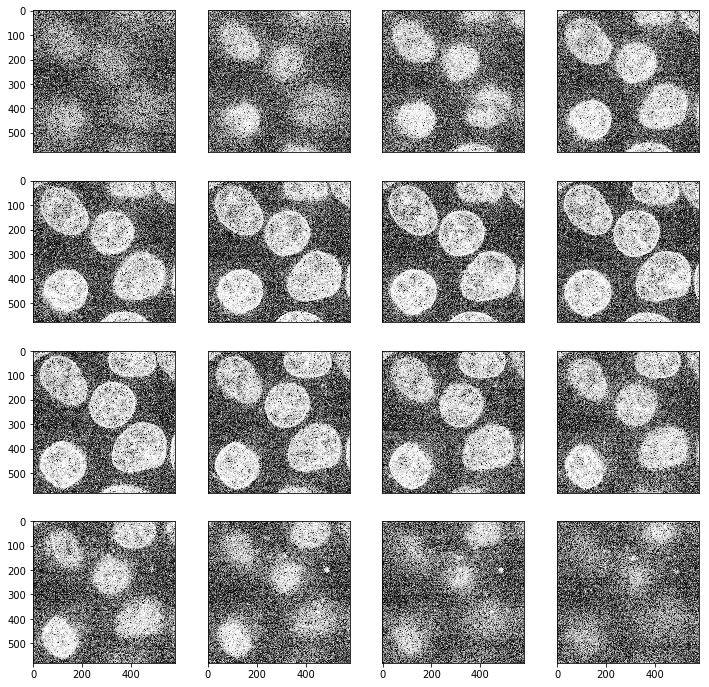

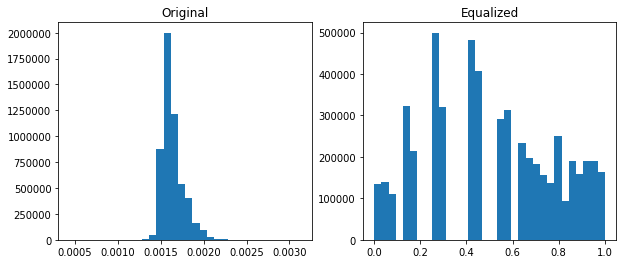

In [6]:
cells = skimage.img_as_float(cells)

equalized = skimage.exposure.equalize_hist(cells)

display(equalized)

_, (a, b) = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize=(10, 4))

a.hist(cells.flatten(), bins=32)
a.set_title("Original")

b.hist(equalized.flatten(), bins=32)
b.set_title("Equalized");

After histogram equalization, we see better contrast between the foreground and background pixels. We also observe much salt-and-pepper noise. This can be removed using morphological opening and closing, followed by a filter.

`skimage.morphology` operations support three-dimensional structures. However, the algorithms assume isotropic volumes. We could squash the structuring element to minimize the plane-dimension contribution. Because structuring element we use is smaller than the spacing in the plane-dimension, we choose to process the image as a series of discrete slices. Any anisotropic algorithm would effectively operate plane-wise.

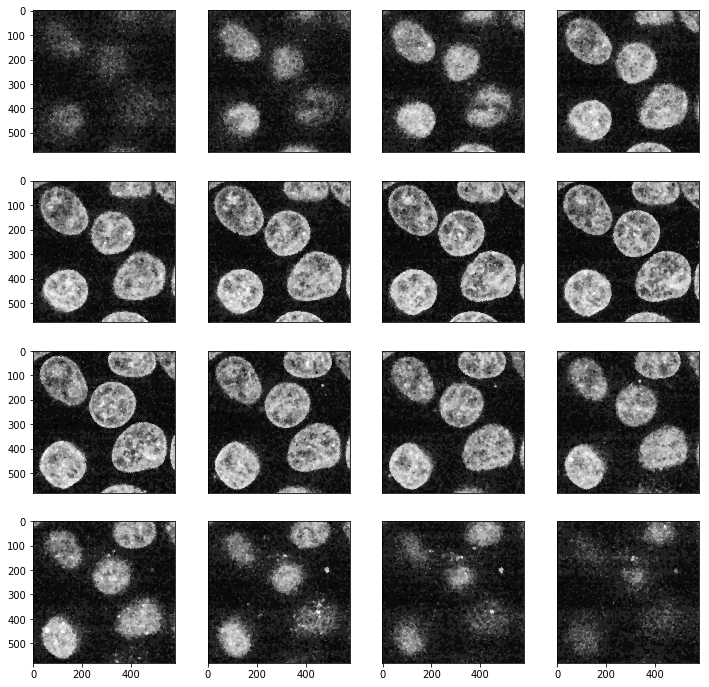

In [103]:
despeckled = numpy.zeros_like(equalized)

selem = skimage.morphology.disk(3)

for index, plane in enumerate(equalized):
    despeckled[index] = skimage.morphology.opening(plane, selem)

for index, plane in enumerate(despeckled):
    despeckled[index] = skimage.morphology.closing(plane, selem)
    
display(despeckled)

Gaussian filtering will remove the remaining noise in the image. The `sigma` parameter can be a scalar or a list of scalars which can be applied to each dimension. Recall that the plane-dimension has a spacing larger than the row- and column-dimensions. We want to reduce the contribution of planes in the calculation of the filter weights. We can adjust `sigma` such that the plane-dimension contribution is less than the row- and column-dimension by dividing a scalar representation of `sigma` by the spacing.

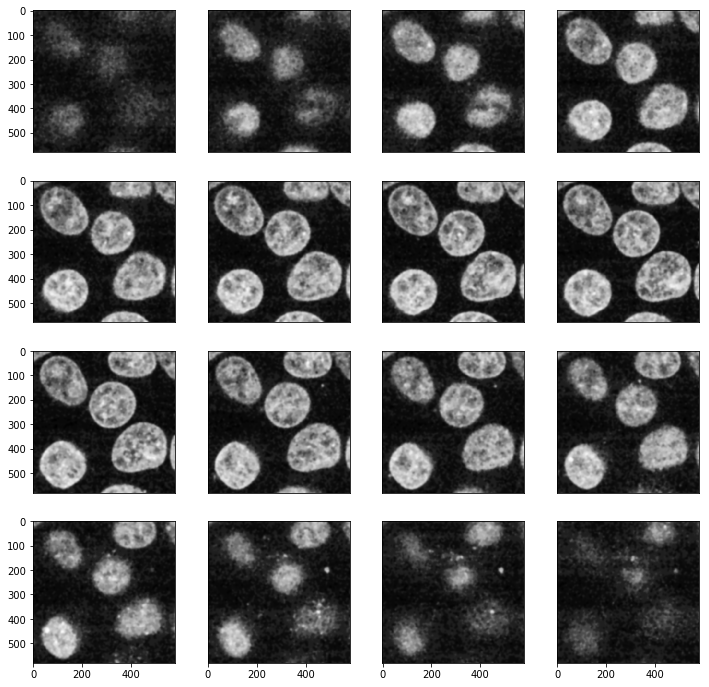

In [104]:
sigma = 3.0 * numpy.divide(spacing[1], spacing)

gaussian = skimage.filters.gaussian(despeckled, sigma)

display(gaussian)

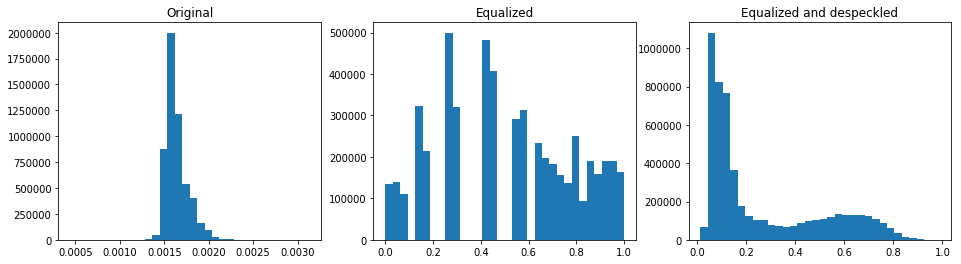

In [105]:
_, (a, b, c) = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(16, 4))

a.hist(cells.flatten(), bins=32)
a.set_title("Original")

b.hist(equalized.flatten(), bins=32)
b.set_title("Equalized")

c.hist(gaussian.flatten(), bins=32)
c.set_title("Equalized and despeckled");

We're beginning to see good separation between the foreground and background in the image. The "Equalized and despeckled" histogram shows a reasonable bimodal distribution. Let's create a binary image by computing Li's minimum cross-entropy threshold and applying it to the image.

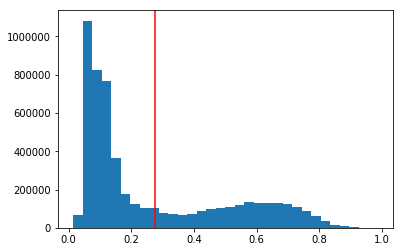

In [106]:
threshold = skimage.filters.threshold_li(gaussian)

matplotlib.pyplot.hist(gaussian.flatten(), bins=32)
matplotlib.pyplot.axvline(x=threshold, color="r")

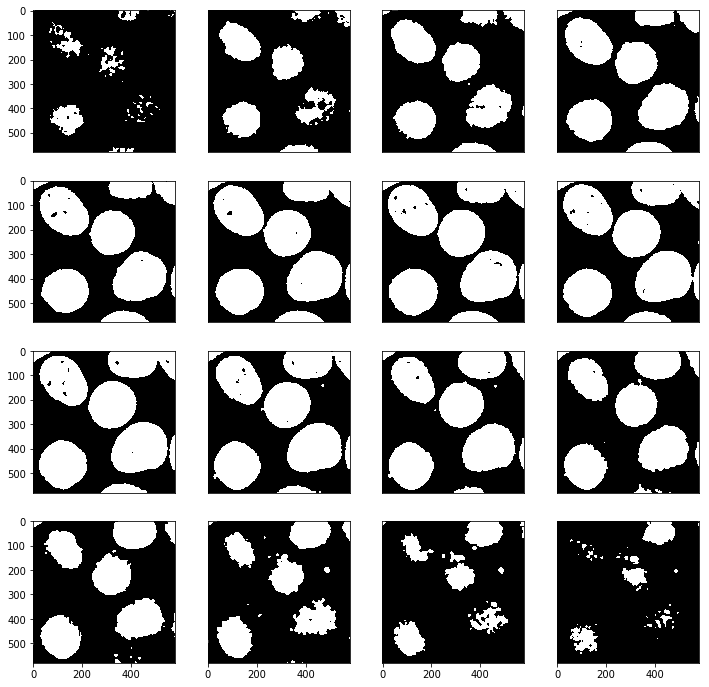

In [107]:
binary = gaussian > threshold

display(binary)

The binary image produced by Li's thresholding looks great! There are a few small holes and artifacts that should be cleaned up before we can segment the image. The operations `skimage.morphology.remove_small_holes` and `skimage.morphology.remove_small_objects` are adaptive for volumes. We define `size_fn` which will help compute the `size` parameter for these functions by taking the diameter of a hole or object and returning its volume.

In [108]:
# Return volume (in pixels) of a sphere with the given diameter.
def size_fn(diameter):
    radius = diameter / 2
    
    return (4 * numpy.pi * (radius ** 2)) / 3

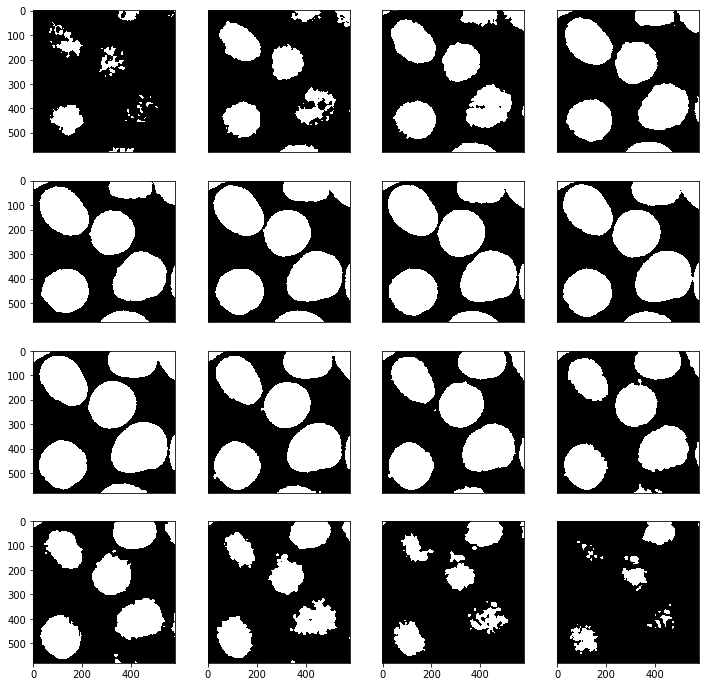

In [109]:
filled = skimage.morphology.remove_small_holes(binary, min_size=size_fn(30))

removed = skimage.morphology.remove_small_objects(filled, min_size=size_fn(40))

display(removed)

Next we'll use `skimage.morphology.watershed` to segment the image and separate the overlapping cells in the upper right corner of the image. Notice the footprint provided to `skimage.feature.peak_local_max` is a three-dimensional structure minimized in the plane-direction proportionally to `spacing`.

In [128]:
# This is a hack to avoid over-segmentation caused by the disjoint 
# ends of objects in the first and final few slices of the volume.
seeded = removed.copy()
seeded[:3] = numpy.zeros_like(removed[:3])
seeded[-3:] = numpy.zeros_like(removed[-3:])

distance = scipy.ndimage.distance_transform_edt(seeded)

local_maxi = skimage.feature.peak_local_max(
    distance, 
    indices=False, 
    footprint=numpy.ones((33 * numpy.divide(spacing[1], spacing)).astype(numpy.uint8)), 
    labels=removed,
)

markers = scipy.ndimage.label(local_maxi)[0]

labels = skimage.morphology.watershed(-distance, markers, mask=removed)

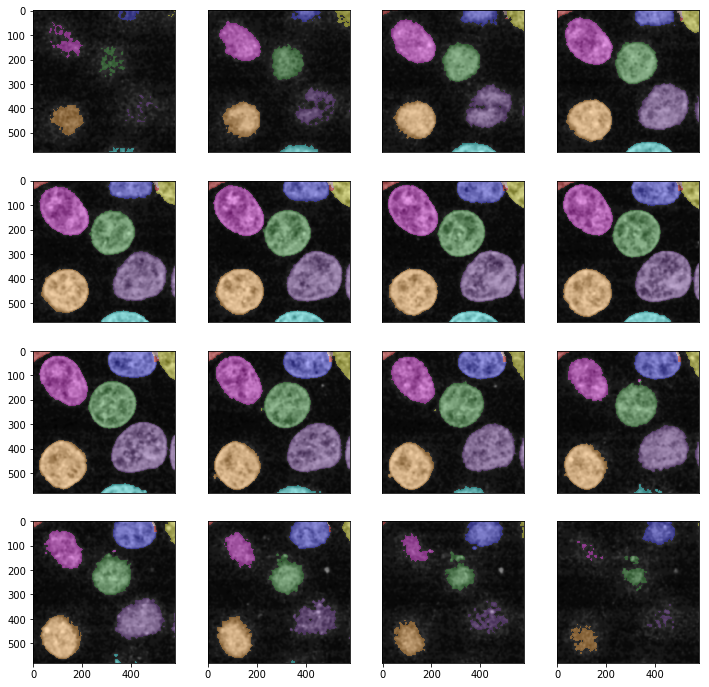

In [129]:
overlay = numpy.zeros((*labels.shape, 3))

for index, plane in enumerate(labels):
    overlay[index] = skimage.color.label2rgb(plane, image=gaussian[index], bg_label=0)

display(overlay, cmap=None)

Feature extraction for three-dimensional segmentations is supported in `skimage.measure`. Several of the properties collected by `skimage.measure.regionprops` support three-dimensional segmentations. The cell below lists which properties are available for three-dimensional segmentations.

In [156]:
region_properties = skimage.measure.regionprops(labels)

supported = [] 

unsupported = []

for prop in region_properties[0]:
    try:
        region_properties[0][prop]
        
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("\n".join(supported))
print()
print("Unsupported properties:")
print("\n".join(unsupported))

Supported properties:
area
bbox
coords
equivalent_diameter
extent
filled_area
filled_image
image
label

Unsupported properties:
centroid
convex_area
convex_image
eccentricity
euler_number
major_axis_length
minor_axis_length
moments
moments_central
moments_hu
moments_normalized
orientation
perimeter
solidity
